# Continuous time simulations

Discrete simulations of discrete models are exact, but discrete simulations of continuous models are only approximations. But how can we run a model in continuous time using the discrete data structures and logic of programming? The big conceptual jump one needs to make to do exact direct simulations of a continuous time process is to think of time in terms of number of events rather than temporal units. By discretely jumping from one event to the next, one can exactly follow the process in continuous time!

## Gillespie's direct simulation

Gillespie popularized the current wave of computational algorithms that exactly simulate a given complex model with many possible reactions or events. In their simplest form, Gillespie algorithms are direct simulations of models in continuous time where a system in state $x(t)$ at time $t$ evolves according to
* Evaluate all the rates $r_i(x,t)$ of all possible events $i$ at time $t$.
* Draw time $\tau_i$ before each of them occur.
* Apply event $i$ with the soonest time $\tau_i$ record that event.
* Update time $t \rightarrow t+\tau_i$ and repeat.

This direct simulation approach applies to any continuous-time model but is computationally expensive!

References: 
- Gillespie (1976), **_A General Method for Numerically Simulating the Stochastic Time Evolution of Coupled Chemical Reactions_** {cite}`gillespie1976general`
- Gillespie (2007), **_Stochastic simulation of chemical kinetics_** {cite}`gillespie2007stochastic`

## Next reaction method

For Markovian models, it is much faster to focus on the time to the *next* event in the series to limit the number of random numbers drawn. One can then, 
* Evaluate all the rates $r_i(x,t)$ of all possible events $i$ as well as their sum $R = \sum_i r_i(x,t)$.
* Draw time $\tau$ to the next event from a total process occurring at rate $R$.
* Pick the exact event $i$ proportionally $r_i(x,t)$, record that event and repeat.

Reference: 
- Gibson and Bruck (2000), **_Efficient Exact Stochastic Simulation of Chemical Systems with Many Species and Many Channels_** {cite}`gibson2000efficient`

Using the continuous cell division example from our discrete algorithms, we can implement the next reaction method like so.

/var/folders/qs/h2k9jxts0n34jj1zq8z7dvtw0000gn/T/ipykernel_3430/2989112677.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['ggplot', 'seaborn-talk'])


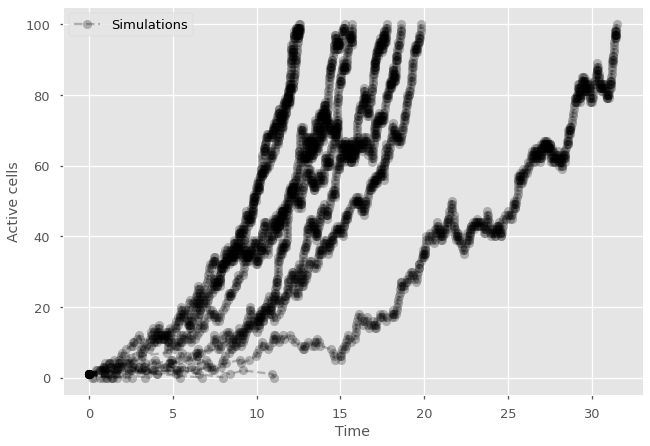

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(['ggplot', 'seaborn-talk'])

#parameters
P_division = 1/2
P_death = 1/3

#for each simulation
for sims in range(25):
    
    #initial conditions
    active_cells = 1
    time = 0
    history = np.ones(1)
    times = np.zeros(1)
    
    #for each generation
    while active_cells < 100 and active_cells > 0:
        
        #calculate total rate R
        R_div = P_division*active_cells
        R_death = P_death*active_cells
        R = R_div + R_death
        
        #draw time to next event and event type
        tau = np.random.exponential(scale=1/R)
        if random.random() < R_div/R:
            active_cells+=1
        else:
            active_cells-=1
            
        #update history
        time = time+tau
        history = np.append(history, active_cells)
        times = np.append(times, time)
        
    #print time series
    plt.plot(times,history, marker="o", ls='--', color='black', alpha=0.25)
    
#Add null simulation with label in legend and label the axes
plt.plot(0,1, marker="o", ls='--', color='black', alpha=0.25, label='Simulations')
plt.legend()
plt.ylabel('Active cells')
plt.xlabel('Time')
plt.show()

:::{seealso}
Recalculating all the rates after each events can be costly. The following event-driven takes care of that easily when only a subset of rates need to be recalculated after each event. Otherwise, one can also use approximative methods such as [tau-leaping](https://en.wikipedia.org/wiki/Tau-leaping) which fixes the rates for a given period of time $\tau$ before recalculating them. Once the rates are fixed, one can quickly draw the next event without any calculations before eventually updating the rates. The larger the leaps $\tau$ the faster the method, but obviously this is no longer an exact simulation of the underlying model as any changes in rates are ignored during the leap.
:::

## General event-driven queuing

The computationally demanding step of the Gillespie family of algorithms is that, to be exact, we in theory have to recalculate (or check) the rate of all possible events before moving on to the next event. Direct simulation is disadvantaged when this step is expansive (for example if all events have their own unique rates that depends on the state of the system) and next reaction methods are disadvantaged if the rates associated with each events vary in time (non-Markovian dynamics). If you're facing such models, the next algorithm will help you out!

Event-driven simulations are essentially next reaction methods *per type of event*. So the question we need to ask the algorithm is not "When is the next reaction occuring?" but "When is this event going to occur? And this one? And this one?" and so on. 

This logic is particularly intuitive on a network so consider Susceptible-Infectious-Recovered dynamics on any network of your choosing. We start with a patient zero with a given set of neighbors. What are the possible events? If that patient zero has three neighbors, then there is one possible recovery event (which occurs at rate $\alpha$) and three possible infection events (which all occur at rate $\beta$). We can ask the algorithm to generate the time to each event independently. What is the time to recovery? Let's keep that time in memory. What is the time to infection of neighbor 1? If that happens after recovery, then keep that time in memory. And so on. Then, we read the events in the order in which the algorithm told us they would occur. If recovery occurs first, we're done! If an infection occurs first, we now need to update our memory [*queue*](https://en.wikipedia.org/wiki/Queue_(abstract_data_type)) and ask the algorithm at what time that node will recover, and when would they infect their neighbors if at all. We keep reading from our memory queue and probing the algorithm whenever needed.

Consider the following function as an example of this queuing idea for infections of new nodes in SIR dynamics on networks.

In [16]:
import numpy as np
import heapq

# New infection: Plan new infections and recovery
def infect_new_node(event_queue, G, node, beta, alpha, t):

    # Set Recovery period
    # The time to a Poisson event 
    #     follows an exponential distribution with average 1/rate
    tau_r = np.random.exponential(scale=1/alpha)
    # Add the recovery to the queue which orders by time, 
    # but also make sure to save information needed: node and event type.
    heapq.heappush(event_queue, (t+tau_r, node, "recovery"))

    # Set infection times
    for neighbor in G.neighbors(node): #loop over ALL neighbors
      #
        tau_i = np.random.exponential(scale=1/beta)
        if tau_i < tau_r:
            heapq.heappush(event_queue, (t+tau_i, neighbor, "infection"))

    return event_queue

We can then use this function within a simpler simulation framework simulation. We simply read and update our memory queue as needed! This is now an event-specific next reaction method, or more commonly: An **event-driven simulation**.

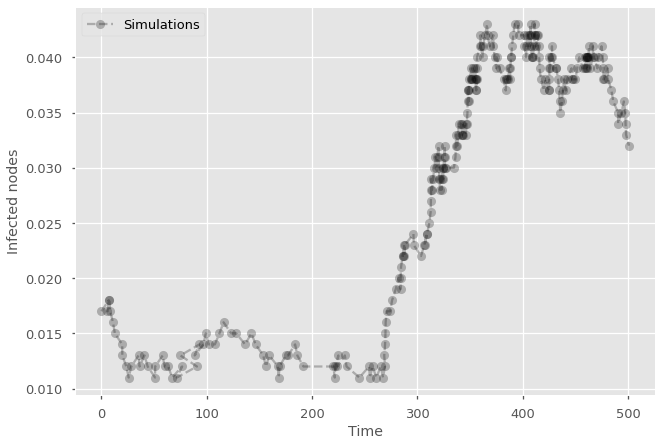

In [17]:
import random
import networkx as nx

# Create a network
G = nx.barabasi_albert_graph(1000, 2)

# Event queue for continuous time events
event_queue = []

# Parameters of the model
beta = 0.0025 #transmission rate
alpha = 0.01 #recovery rate
I0 = 0.01 #initial fraction of infected nodes

# Initial conditions
t = 0
I = 0
for node in list(G.nodes()): #loop over nodes
    G.nodes[node]['state'] = 'susceptible'
    if random.random()<I0:
        G.nodes[node]['state'] = 'infected'
        event_queue = infect_new_node(event_queue, G, node, beta, alpha, t)
        I += 1
        
# Counter
history = []
times = []
history.append(I/G.number_of_nodes())
times.append(t)

# Simulation
tmax = 500
while t<tmax:
    (time, node, event) = heapq.heappop(event_queue)
    if event == 'recovery' and G.nodes[node]['state'] == 'infected':
        G.nodes[node]['state'] = 'recovered'
        I -= 1
    if event == 'infection' and G.nodes[node]['state'] == 'susceptible':
        G.nodes[node]['state'] = 'infected'
        event_queue = infect_new_node(event_queue, G, node, beta, alpha, t)
        I += 1
    t=time
    history.append(I/G.number_of_nodes())
    times.append(t)

#Add null simulation with label in legend and label the axes
plt.plot(times,history, marker="o", ls='--', color='black', alpha=0.25, label='Simulations')
plt.legend()
plt.ylabel('Infected nodes')
plt.xlabel('Time')
plt.show()